In [59]:
import urllib2
import re
from bs4 import BeautifulSoup
import gensim
from gensim import corpora
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
from sklearn.feature_extraction import DictVectorizer
import string
import itertools
import matplotlib.pyplot as plt



%matplotlib inline


In [35]:
food_region = ["indian", "lebanese", "korean", "italian"]
search_page = ["1", "2", "3", "4"]

url_str = 'http://allrecipes.com/search/results/?wt={}&sort=re&page={}'

search_comb = itertools.product(food_region, search_page)
region_urls = [url_str.format(region[0],region[1]) for region in search_comb]


In [36]:
recipe_index_urls = []
for u in region_urls:
    soup = BeautifulSoup(urllib2.urlopen(u).read())
    li = (soup.find_all("a", attrs={"href":re.compile("/recipe/.*"), 
                                      "data-internal-referrer-link":"hub recipe"}))
    recipe_index_urls.extend([i['href'] for i in li][1::2])
    

In [37]:
all_recipe_ing = []
for u in recipe_index_urls:
    soup = BeautifulSoup(urllib2.urlopen("http://www.allrecipes.com" + u).read())
    items = soup.findAll(attrs={"itemprop": "ingredients"})
    items = " ".join([s.get_text().encode("ascii", "ignore") for s in items])
    all_recipe_ing.extend([items])

In [38]:
other = ({u'fresh', u'ground', u'ounce', u'pound', u'inch', u'tablespoon', u'teaspoon', u'cup', 
          u'package', u'optional', u'pinch', u'taste', u'cut', u'diced', 
          u'chopped', u'minced', u'sliced', u'thinly'})
stop = set(stopwords.words('english'))
punct = set(string.punctuation) 
lemma = WordNetLemmatizer()

def remove_irrelevant(doc):
    cur_vect = " ".join([word for word in doc.lower().split() if word not in stop])    
    cur_vect = " ".join([lemma.lemmatize(word) for word in cur_vect.split()])
    cur_vect = ''.join([word for word in cur_vect if word not in punct])
    cur_vect = " ".join([word for word in cur_vect.split() if word not in other]) 
    cur_vect = ''.join([word for word in cur_vect if not word.isdigit()])
    return cur_vect


all_recipe_ing_clean = [remove_irrelevant(i).split() for i in all_recipe_ing]        


In [43]:
dictionary = corpora.Dictionary(all_recipe_ing_clean)
doc_term_matrix = [dictionary.doc2bow(il) for il in all_recipe_ing_clean]

n_topic = 4

lda = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=n_topic, id2word = dictionary, passes=50)

In [97]:
lda.show_topics(num_words=10, formatted=True)

[(0,
  u'0.027*"dried" + 0.024*"pepper" + 0.023*"salt" + 0.021*"cheese" + 0.019*"oil" + 0.018*"garlic" + 0.018*"onion" + 0.018*"white" + 0.016*"sugar" + 0.016*"olive"'),
 (1,
  u'0.039*"salt" + 0.036*"oil" + 0.029*"garlic" + 0.028*"cumin" + 0.028*"clove" + 0.025*"pepper" + 0.021*"seed" + 0.019*"onion" + 0.019*"turmeric" + 0.017*"water"'),
 (2,
  u'0.035*"large" + 0.031*"pepper" + 0.030*"oil" + 0.024*"salt" + 0.022*"chicken" + 0.019*"boneless" + 0.019*"garlic" + 0.017*"skinless" + 0.016*"onion" + 0.016*"olive"'),
 (3,
  u'0.034*"oil" + 0.033*"pepper" + 0.033*"sesame" + 0.032*"sauce" + 0.030*"white" + 0.027*"sugar" + 0.025*"soy" + 0.025*"garlic" + 0.024*"onion" + 0.023*"water"')]

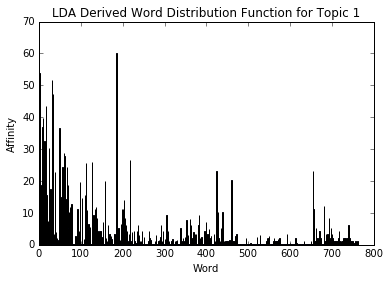

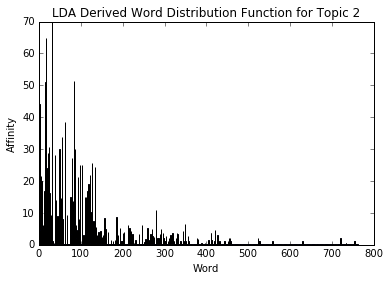

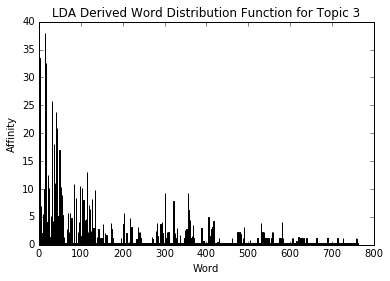

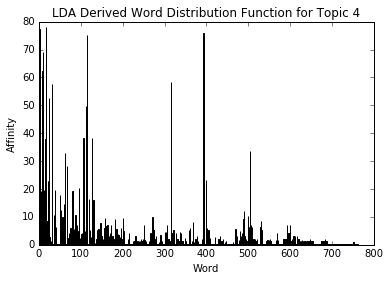

In [388]:

for i in range(4):
    plt.figure()
    plt.title("LDA Derived Word Distribution Function for Topic {}".format(i+1))

    plt.bar(range(len(lda.state.get_lambda()[i])), lda.state.get_lambda()[i])
    plt.xlabel('Word')
    plt.ylabel('Affinity')

In [ ]:
[dictionary.get(i) for i in range(len(lda.state.get_lambda()[0])) if lda.state.get_lambda()[0][i] > 30]
[dictionary.get(i) for i in range(len(lda.state.get_lambda()[1])) if lda.state.get_lambda()[1][i] > 30]
[dictionary.get(i) for i in range(len(lda.state.get_lambda()[2])) if lda.state.get_lambda()[2][i] > 30]
[dictionary.get(i) for i in range(len(lda.state.get_lambda()[3])) if lda.state.get_lambda()[3][i] > 50]


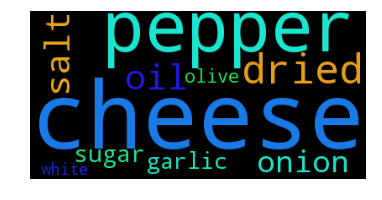

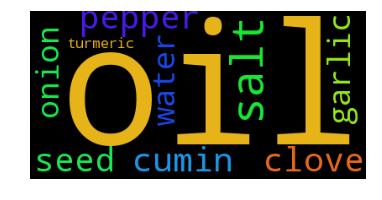

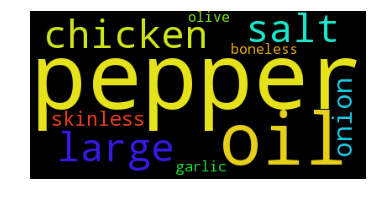

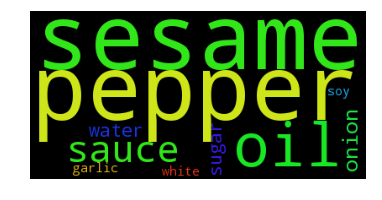

In [382]:
for i in range(0, n_topic):
    copy_words_prop = lda.show_topic(i, 10)
    copy_words_prop = " ".join([" ".join(int(100*j[1]) * [j[0]]) for j in copy_words_prop])
    wc = WordCloud(background_color="black").generate(copy_words_prop)
        
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")


In [366]:
rows = []
for i in xrange(len(doc_term_matrix)):
    row = dict(((dictionary.get(j[0]),j[1]) for j in doc_term_matrix[i]))
    rows.append(row)


vec = DictVectorizer()
X = vec.fit_transform(rows)

MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(X)
pts = mds.fit_transform(dist) 


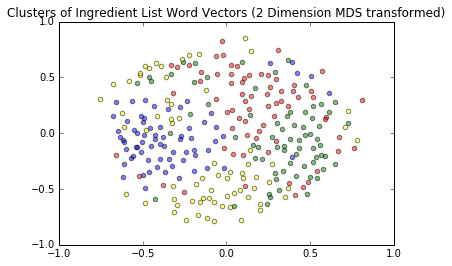

In [387]:
colors = (70*['red'])
colors.extend(70*['green'])
colors.extend(70*['blue'])
colors.extend(69*['yellow'])

plt.figure()
plt.title("Clusters of Ingredient List Word Vectors (2 Dimension MDS transformed)")

for i in xrange(X_pca.shape[0]):
    plt.scatter(pts[i, 0], pts[i, 1], alpha=.5, c=colors[i])
        
plt.legend()
